---
# ***SETTINGS***
---

In [1]:
# SARA: montiamo a drive per collegarci alla cartella desiderata
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# IMPORT LIBRARIES
import json
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import math
from re import X
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D, Multiply, Reshape, Dense
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers

import random
import numpy as np
seed = 4

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

---
# ***DATAFRAME CREATION***
---

In [3]:
# I CREATE A LIST OD SINGLE DATAFRAMES AND THEN I CONCATENATE ALL OF THEM FOR MY FUTURE CLASSIFICATION TASK
dfs_list = []
lenght =  []
phases = []

# Iterate through all the JSON files in the specified range
for i in range(0, 22):
    # Generate the file name (assuming the format is POWxxx.json)
    json_file_name = f'POW{i:03d}.json'
    json_file_path = os.path.join('/content/gdrive/MyDrive/SAPIENS/DB_Macchinine', json_file_name)

    # Check if the file exists before attempting to read it
    if os.path.exists(json_file_path):
        with open(json_file_path, 'r') as json_file:
            data = json.load(json_file)

        rows = []
        # Iterate through the JSON data
        for key, value in data.items():
            user_id = value['UserID']
            readings = value['Readings']

            for reading_key, reading_value in readings.items():
                phase = reading_value['Phase']
                if phase not in phases:
                  phases.append(phase)
                if phase in  ["sudoku", "Sudoku", "Baseline 000", "baseline 001", "Baseline 002", "Baseline 003"]:
                    time = reading_value['Time']
                    af3_theta = reading_value['AF3']['Theta']
                    af3_alpha = reading_value['AF3']['Alpha']
                    af3_betaL = reading_value['AF3']['BetaL']
                    af3_betaH = reading_value['AF3']['BetaH']
                    af3_gamma = reading_value['AF3']['Gamma']

                    t7_theta = reading_value['T7']['Theta']
                    t7_alpha = reading_value['T7']['Alpha']
                    t7_betaL = reading_value['T7']['BetaL']
                    t7_betaH = reading_value['T7']['BetaH']
                    t7_gamma = reading_value['T7']['Gamma']

                    pz_theta = reading_value['Pz']['Theta']
                    pz_alpha = reading_value['Pz']['Alpha']
                    pz_betaL = reading_value['Pz']['BetaL']
                    pz_betaH = reading_value['Pz']['BetaH']
                    pz_gamma = reading_value['Pz']['Gamma']

                    t8_theta = reading_value['T8']['Theta']
                    t8_alpha = reading_value['T8']['Alpha']
                    t8_betaL = reading_value['T8']['BetaL']
                    t8_betaH = reading_value['T8']['BetaH']
                    t8_gamma = reading_value['T8']['Gamma']

                    af4_theta = reading_value['AF4']['Theta']
                    af4_alpha = reading_value['AF4']['Alpha']
                    af4_betaL = reading_value['AF4']['BetaL']
                    af4_betaH = reading_value['AF4']['BetaH']
                    af4_gamma = reading_value['AF4']['Gamma']


                    row = [user_id, phase, time, af3_theta, af3_alpha, af3_betaL, af3_betaH, af3_gamma, t7_theta, t7_alpha, t7_betaL, t7_betaH, t7_gamma,
                           pz_theta, pz_alpha, pz_betaL, pz_betaH, pz_gamma, t8_theta, t8_alpha, t8_betaL, t8_betaH, t8_gamma,
                           af4_theta, af4_alpha, af4_betaL, af4_betaH, af4_gamma]

                    rows.append(row)

    # Define columns as before
    columns = ['UserID', 'Phase', 'Time', 'AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
           'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
           'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
           'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
           'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma']

    # Create a DataFrame from the rows and columns
    df = pd.DataFrame(rows, columns=columns)

    # Filter the DataFrame to only include rows with 'Phase' as "sudoku" or "baseline occhi chiusi"
    filtered_df = df[df['Phase'].isin(["Baseline 000", "sudoku", "baseline 001", "Sudoku", "Baseline 002", "Baseline 003", "baseline occhi aperti", "Baseline 005", "Baseline 006 F23", "baseline 007", "Baseline 008", "Baseline occhi aperti 009", "baseline occhi aperti 010", "baseline 011", "baseline", "baseline 014", "baseline 015", "Baseline 016", "baseline 017", "baseline 018", "Baseline 019", "baseline 020", "baseline 021"])]

    # I do not need UserID and Time
    columns_to_remove = ['UserID', 'Time']
    filtered_df.drop(columns=columns_to_remove, inplace=True)
    lenght.append(len(filtered_df))

    # LIST OF ALL DATAFRAMES
    dfs_list.append(filtered_df)

# FINAL COLLECTIVE DATAFRAME
df_final = pd.concat(dfs_list, ignore_index=True)

print(df_final.shape)
df_final.head()

(39361, 26)


,Phase,AF3_Theta,AF3_Alpha,AF3_BetaL,AF3_BetaH,AF3_Gamma,T7_Theta,T7_Alpha,T7_BetaL,T7_BetaH,...,T8_Theta,T8_Alpha,T8_BetaL,T8_BetaH,T8_Gamma,AF4_Theta,AF4_Alpha,AF4_BetaL,AF4_BetaH,AF4_Gamma
0,Baseline 000,2.491,2.108,0.544,2.437,0.562,1.331,0.485,0.487,2.687,...,1.72,1.423,1.564,4.624,1.89,4.469,2.61,0.486,2.134,0.673
1,Baseline 000,2.569,2.127,0.651,2.522,0.567,1.193,0.401,0.616,2.201,...,1.719,1.378,1.534,3.993,1.575,4.383,2.534,0.49,2.117,0.685
2,Baseline 000,2.562,2.233,0.876,2.536,0.595,1.098,0.317,0.745,1.717,...,1.71,1.44,1.466,3.279,1.221,4.062,2.544,0.627,2.064,0.718
3,Baseline 000,2.476,2.419,1.16,2.468,0.655,1.143,0.274,0.865,1.359,...,1.634,1.596,1.365,2.691,0.932,3.547,2.69,0.827,1.983,0.78
4,Baseline 000,2.501,2.645,1.439,2.328,0.74,1.304,0.311,0.978,1.217,...,1.524,1.821,1.257,2.34,0.761,3.215,2.957,1.04,1.886,0.855


In [4]:
phases

['Baseline 000',
 'baseline occhi chiusi',
 'Test macchinine che funzionano, magari',
 'sudoku',
 'Macchinine con musica ',
 'Macchinine Giuste',
 'boh',
 'baseline 001',
 'Macchinine 1',
 'Sudoku',
 'sudoku + macchine',
 'Baseline 002',
 'Baseline occhi chiusi',
 'macchinine 2',
 'Baseline 003',
 'occhi chiusi',
 'macchinine 1',
 'macchinine + fine sudoku',
 'baseline occhi aperti',
 'Macchinine 2.0',
 'Baseline 005',
 'Macchinine1',
 'M1',
 'Waves,       AF3/theta,AF3/alpha,AF3/betaL,AF3/betaH,AF3/gamma,T7/theta,T7/alpha,T7/betaL,T7/betaH,T7/gamma,Pz/theta,Pz/alpha,Pz/betaL,Pz/betaH,Pz/gamma,T8/theta,T8/alpha,T8/betaL,T8/betaH,T8/gamma,AF4/theta,AF4/alpha,AF4/betaL,AF4/betaH,AF4/gamma',
 'Baseline 006 F23',
 '222',
 'macchine 2',
 'm1',
 'baseline 007',
 'Baseline 008',
 'Baseline occhi aperti 009',
 'Macchinine 2',
 'baseline occhi aperti 010',
 'nulla',
 'baseline 011',
 '& C:/Users/Cerio/AppData/Local/Microsoft/WindowsApps/python3.8.exe "c:/Users/Cerio/Studio/Poli - Biomedica/2 - 

In [5]:
# MISSING VALUES CHECK
df_final.isna().any()

Phase        False
AF3_Theta    False
AF3_Alpha    False
AF3_BetaL    False
AF3_BetaH    False
AF3_Gamma    False
T7_Theta     False
T7_Alpha     False
T7_BetaL     False
T7_BetaH     False
T7_Gamma     False
Pz_Theta     False
Pz_Alpha     False
Pz_BetaL     False
Pz_BetaH     False
Pz_Gamma     False
T8_Theta     False
T8_Alpha     False
T8_BetaL     False
T8_BetaH     False
T8_Gamma     False
AF4_Theta    False
AF4_Alpha    False
AF4_BetaL    False
AF4_BetaH    False
AF4_Gamma    False
dtype: bool

In [6]:
# Use the astype method to convert columns to float
columns_to_convert = [
    'AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
    'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
    'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
    'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
    'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma'
]

# total df
df_final[columns_to_convert] = df_final[columns_to_convert].astype(float)

# all dfs
for i in dfs_list:
  i[columns_to_convert] = i[columns_to_convert].astype(float)

In [7]:
print(df_final.dtypes)

Phase         object
AF3_Theta    float64
AF3_Alpha    float64
AF3_BetaL    float64
AF3_BetaH    float64
AF3_Gamma    float64
T7_Theta     float64
T7_Alpha     float64
T7_BetaL     float64
T7_BetaH     float64
T7_Gamma     float64
Pz_Theta     float64
Pz_Alpha     float64
Pz_BetaL     float64
Pz_BetaH     float64
Pz_Gamma     float64
T8_Theta     float64
T8_Alpha     float64
T8_BetaL     float64
T8_BetaH     float64
T8_Gamma     float64
AF4_Theta    float64
AF4_Alpha    float64
AF4_BetaL    float64
AF4_BetaH    float64
AF4_Gamma    float64
dtype: object


---
# ***CLASSIFICATION***
---

In [8]:
# I need only data, not phase names
x = df_final
z = x.drop(columns = 'Phase')

# Conversion to numpy array
xnew = z.to_numpy()
# Let's check the shape
print(xnew.shape)

(39361, 25)


In [9]:
# Labels: I need a one-hot encoder. I realize the most basic (and stupid) one.
# I know there also the tfkl function "to_categorical()" but I gives me an error
# and now I don't have time to solve it
y = df_final['Phase']

labels = []
for i in y:
  if i == "Baseline 000" or i == "baseline 001" or i == "Baseline 002" or i == "Baseline 003" or i == "baseline occhi aperti" or i == "Baseline 005" or i == "Baseline 006 F23" or i == "baseline 007" or i == "Baseline 008" or i == "Baseline occhi aperti 009" or i == "baseline occhi aperti 010" or i == "baseline 011" or i == "baseline" or i == "baseline 014" or i == "baseline 015" or i == "Baseline 016" or i == "baseline 017" or i == "baseline 018" or i == "Baseline 019" or i == "baseline 020" or i == "baseline 021":
    labels.append(1)
  elif i == 'sudoku' or i == 'Sudoku':
    labels.append(0)

# conversion to array and shape check
labels = np.asarray(labels)
print("Original labels: ", labels.shape)

cat_labels = to_categorical(labels)
print("Categorical labels: ", cat_labels.shape)

Original labels:  (39361,)
Categorical labels:  (39361, 2)


In [10]:
# SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(xnew, cat_labels,
                                                    test_size =0.20,
                                                    random_state= seed)   #fix random seed for replicability

# Now split again into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=seed)

print( "X train shape:", X_train.shape, "X test shape:", X_test.shape, "X val shape:", X_val.shape, "y train shape:", y_train.shape, "y test shape:", y_test.shape, "y val shape:", y_val.shape)

X train shape: (25190, 25) X test shape: (7873, 25) X val shape: (6298, 25) y train shape: (25190, 2) y test shape: (7873, 2) y val shape: (6298, 2)


In [11]:
y_train_len = len(y_train)

train_labels = labels[:y_train_len]
print(len(train_labels))

25190


In [12]:
# CLASS BALANCING
weights = compute_class_weight('balanced', classes=[0, 1], y=train_labels)

# Creare un dizionario di pesi delle classi
weights_dict = {classe: peso for classe, peso in zip([0, 1], weights)}

# Stampa dei pesi delle classi
print("Classes weights:", weights_dict)

Classes weights: {0: 0.646129379777356, 1: 2.21081270844304}


In [13]:
y_train.dtype

dtype('float32')

In [14]:
# my model
def CNN1D_classifier(input_shape, label):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu', name = "prova")(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    classifier = tfkl.Dense(1024, activation='relu')(dropout)
    dropout2 = tfkl.Dropout(.3, seed=seed)(classifier)
    output_layer = tfkl.Dense(2, activation='softmax')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    opt = tf.keras.optimizers.Adam(
      learning_rate = 2e-4,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-08,
      amsgrad=False,
      name="Adam",
    )
    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    #model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')


    # Return the model
    return model

model = CNN1D_classifier((25, 1), labels)

In [15]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 32,
    class_weight = weights_dict,
    epochs = 32,
    validation_data=(X_test, y_test),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)] # I should recompile with a higher patience
).history

Epoch 1/32
788/788 [==============================] - 17s 7ms/step - loss: 1.2108 - accuracy: 0.7582 - val_loss: 0.5144 - val_accuracy: 0.7213
Epoch 2/32
788/788 [==============================] - 4s 5ms/step - loss: 0.4909 - accuracy: 0.8017 - val_loss: 0.5040 - val_accuracy: 0.7611
Epoch 3/32
788/788 [==============================] - 4s 5ms/step - loss: 0.4307 - accuracy: 0.8200 - val_loss: 0.4087 - val_accuracy: 0.7919
Epoch 4/32
788/788 [==============================] - 6s 8ms/step - loss: 0.3730 - accuracy: 0.8364 - val_loss: 0.3272 - val_accuracy: 0.8678
Epoch 5/32
788/788 [==============================] - 4s 6ms/step - loss: 0.3798 - accuracy: 0.8434 - val_loss: 0.3568 - val_accuracy: 0.8285
Epoch 6/32
788/788 [==============================] - 4s 5ms/step - loss: 0.3306 - accuracy: 0.8521 - val_loss: 0.4425 - val_accuracy: 0.8381
Epoch 7/32
788/788 [==============================] - 6s 7ms/step - loss: 0.3153 - accuracy: 0.8559 - val_loss: 0.2887 - val_accuracy: 0.8610
Epoch

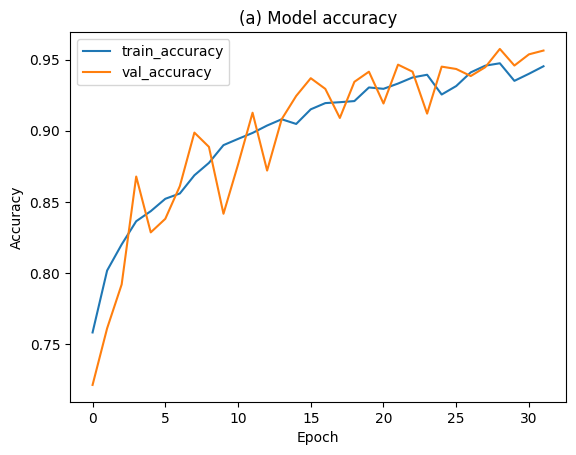

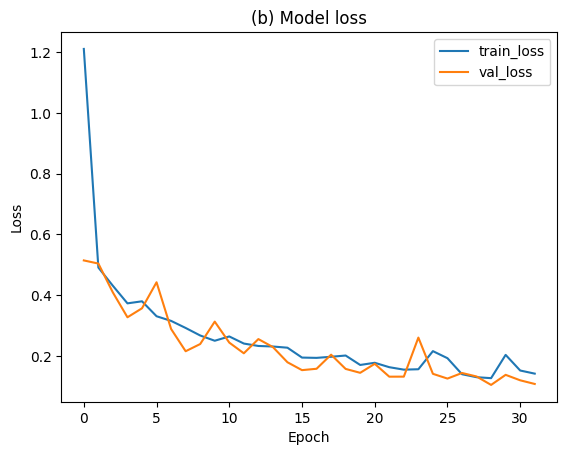

In [16]:
# Plot training & validation accuracy values
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'])
plt.title('(a) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.title('(b) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [17]:
#X_test = X_test.astype(float)
from time import time

startTime = time()
y_pred = model.predict(X_val)
correct_predictions = 0
finalTime = time()

correct_predictions = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_val, axis=1))
total_predictions = len(y_pred)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

197/197 [==============================] - 1s 2ms/step
Accuracy: 95.74%	Total time for 6298 predictions: 0.68 seconds


---
# ***RIFERIMENTO A BASELINE***
---

In [18]:
# Lista di valori per il confronto
fasi_di_interesse = ["Baseline 000", "baseline 001", "Baseline 002", "Baseline 003", "baseline occhi aperti", "Baseline 005", "Baseline 006 F23", "baseline 007","Baseline 008", "Baseline occhi aperti 009", "baseline occhi aperti 010", "baseline 011", "baseline", "baseline 014", "baseline 015", "Baseline 016", "baseline 017" , "baseline 018", "Baseline 019", "baseline 020", "baseline 021"]

# Seleziona solo le righe con le fasi di interesse
dati_relax = x[x['Phase'].str.lower().isin([fase.lower() for fase in fasi_di_interesse])]

# Ora puoi continuare con il calcolo della media sui dati selezionati
media_relax = dati_relax.mean().mean()

x2 = x.copy()

nuove_fasi = ['Sudoku', 'sudoku']
colonne_numeriche = x.select_dtypes(include='number').columns
x2[colonne_numeriche] = x2[colonne_numeriche] - media_relax

z2 = x2.drop(columns = 'Phase')

# Conversion to numpy array
xnew2 = z.to_numpy()
# Let's check the shape
print(xnew2.shape)

(39361, 25)


<ipython-input-18-dce580f408d6>:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  media_relax = dati_relax.mean().mean()


In [19]:
# SPLIT DATA INTO TRAIN AND TEST SET
X_train2, X_test2, y_train2, y_test2 = train_test_split(xnew2, cat_labels,
                                                    test_size =0.20,
                                                    random_state= seed)   #fix random seed for replicability

# Now split again into train and validation
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.20, random_state=seed)

print( "X train shape:", X_train.shape, "X test shape:", X_test.shape, "X val shape:", X_val.shape, "y train shape:", y_train.shape, "y test shape:", y_test.shape, "y val shape:", y_val.shape)

X train shape: (25190, 25) X test shape: (7873, 25) X val shape: (6298, 25) y train shape: (25190, 2) y test shape: (7873, 2) y val shape: (6298, 2)


In [20]:
# Train the model
history = model.fit(
    x = X_train2,
    y = y_train2,
    batch_size = 32,
    class_weight = weights_dict,
    epochs = 32,
    validation_data=(X_test2, y_test2),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)] # I should recompile with a higher patience
).history

Epoch 1/32
788/788 [==============================] - 5s 6ms/step - loss: 0.1242 - accuracy: 0.9520 - val_loss: 0.1167 - val_accuracy: 0.9508
Epoch 2/32
788/788 [==============================] - 7s 8ms/step - loss: 0.1183 - accuracy: 0.9529 - val_loss: 0.1139 - val_accuracy: 0.9524
Epoch 3/32
788/788 [==============================] - 4s 5ms/step - loss: 0.1269 - accuracy: 0.9518 - val_loss: 0.1054 - val_accuracy: 0.9588
Epoch 4/32
788/788 [==============================] - 4s 5ms/step - loss: 0.1108 - accuracy: 0.9547 - val_loss: 0.1090 - val_accuracy: 0.9555
Epoch 5/32
788/788 [==============================] - 7s 8ms/step - loss: 0.1207 - accuracy: 0.9543 - val_loss: 0.1742 - val_accuracy: 0.9324
Epoch 6/32
788/788 [==============================] - 4s 6ms/step - loss: 0.1961 - accuracy: 0.9471 - val_loss: 0.1227 - val_accuracy: 0.9545
Epoch 7/32
788/788 [==============================] - 4s 6ms/step - loss: 0.1061 - accuracy: 0.9570 - val_loss: 0.0995 - val_accuracy: 0.9601
Epoch 

In [21]:
#X_test = X_test.astype(float)
from time import time

startTime = time()
y_pred = model.predict(X_val2)
correct_predictions = 0
finalTime = time()

correct_predictions = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_val2, axis=1))
total_predictions = len(y_pred)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

197/197 [==============================] - 0s 2ms/step
Accuracy: 96.14%	Total time for 6298 predictions: 0.48 seconds


---
# ***KNN + ADABOOST***
---

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Crea il classificatore KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Crea il classificatore DecisionTreeClassifier come classificatore base per AdaBoost
base_classifier = DecisionTreeClassifier(max_depth=1)  # Puoi personalizzare max_depth a seconda delle tue esigenze

# Crea il classificatore AdaBoost con DecisionTreeClassifier come classificatore base
adaboost_classifier = AdaBoostClassifier(base_estimator=base_classifier, n_estimators=50, random_state=42)


# Addestra il modello
adaboost_classifier.fit(X_train, train_labels)

#X_test = X_test.astype(float)
from time import time

startTime = time()
y_pred = model.predict(X_val)
correct_predictions = 0
finalTime = time()

correct_predictions = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_val, axis=1))
total_predictions = len(y_pred)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


197/197 [==============================] - 0s 2ms/step
Accuracy: 96.14%	Total time for 6298 predictions: 0.50 seconds


In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Crea il classificatore KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Crea il classificatore DecisionTreeClassifier come classificatore base per AdaBoost
base_classifier = DecisionTreeClassifier(max_depth=1)  # Puoi personalizzare max_depth a seconda delle tue esigenze

# Crea il classificatore AdaBoost con DecisionTreeClassifier come classificatore base
adaboost_classifier = AdaBoostClassifier(base_estimator=base_classifier, n_estimators=50, random_state=42)


# Addestra il modello
adaboost_classifier.fit(X_train2, train_labels)

#X_test = X_test.astype(float)
from time import time

startTime = time()
y_pred = model.predict(X_val2)
correct_predictions = 0
finalTime = time()

correct_predictions = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_val2, axis=1))
total_predictions = len(y_pred)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


197/197 [==============================] - 1s 3ms/step
Accuracy: 96.14%	Total time for 6298 predictions: 0.69 seconds
